In [1]:
import os
import pandas as pd
from rxnmapper import RXNMapper
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
from rdchiral.template_extractor import extract_from_reaction
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants
from tqdm import tqdm
tqdm.pandas()
import torch


rxn_mapper = RXNMapper()


Some weights of the model checkpoint at /home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.weight', 'predictions.dense.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
def get_mcsa_normal_dataset(dir, subset=['train', 'valid'], flag='mcsa', read_new=False):
    dataset = pd.DataFrame()
    for dataset_flag in subset:
        sub_df = pd.read_csv(os.path.join(dir, f'{dataset_flag}_dataset' if not read_new else f'new_{dataset_flag}_dataset', f'{flag}_{dataset_flag}.csv'))
        sub_df['dataset_flag'] = [dataset_flag for _ in range(len(sub_df))]
        dataset = pd.concat([dataset, sub_df])
    dataset = dataset.reset_index(drop=True)
    return dataset

def get_reaction_smiles(reaction):
    # reaction 格式为：底物SMILES|酶序列>>产物SMILES
    precursors, products = reaction.split('>>')
    substrates, aa_sequence = precursors.split('|')
    return f'{substrates}>>{products}'


def mapping_reaction(rxn_smiles):
    try:
        results = rxn_mapper.get_attention_guided_atom_maps([rxn_smiles])[0]
        mapped_rxn = results['mapped_rxn']
    except Exception as e:
        print(e)
        print(f'Erro in {rxn_smiles}')
        mapped_rxn = ''
    return mapped_rxn
    
def canonicalize_smiles(smiles, remove_map=True):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        if remove_map:
            [a.ClearProp('molAtomMapNumber') for a in mol.GetAtoms() if a.HasProp('molAtomMapNumber')]
        return Chem.MolToSmiles(mol)
    else:
        return ''
    
def get_fixed_prec(rxn_smiles):
    
    reactants, products = rxn_smiles.split('>>')
    reactants_list = reactants.split('.')
    products_list = products.split('.')
    
    fixed_reactants_list = []
    for react in reactants_list:
        if (react not in products_list) and (':' in react):
            fixed_reactants_list.append(react)
    
    return canonicalize_smiles('.'.join(fixed_reactants_list))

    
def get_templates(rxn_smi,  
                  add_brackets=True, validate=False):
    """
    Adapt from https://github.com/hesther/templatecorr/blob/main/templatecorr/extract_templates.py#L22

    Extracts a template at a specified level of specificity for a reaction smiles.

    :param rxn_smi: Reaction smiles string
    :param no_special_groups: Boolean whether to omit special groups in template extraction
    :param radius: Integer at which radius to extract templates
    :param add_brackets: Whether to add brackets to make template pseudo-unimolecular

    :return: Template
    """    
    #Extract:
   
    try:
        rxn_split = rxn_smi.split(">")
        reaction={"_id":0,"reactants":rxn_split[0],"spectator":rxn_split[1],"products":rxn_split[2]}
        template = extract_from_reaction(reaction)["reaction_smarts"]
        if add_brackets:
            template = "(" + template.replace(">>", ")>>")
    except:
        template = ''
    
    if validate:
    #Validate:
        if template != '':
            
            prec = get_fixed_prec(rxn_smi)
            
            rct = rdchiralReactants(rxn_smi.split(">")[-1])
            try:
                rxn = rdchiralReaction(template)
                outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
            except:
                outcomes =[]
            if not prec in outcomes:

                print('template:')
                print(template)
                print('rxn_smiles:')
                print(rxn_smi+'\n')
                
                template=''
            
    return template
    
def assign_mapper(rxn_smiles, mapper_list):
    reactants, products = rxn_smiles.split('>>')
    mol_reactants, mol_products = Chem.MolFromSmiles(reactants), Chem.MolFromSmiles(products)
    for prod_idx in range(mol_products.GetNumAtoms()):
        mol_products.GetAtomWithIdx(prod_idx).SetProp('molAtomMapNumber', str(prod_idx+1))
        react_idx = mapper_list[0][prod_idx]
        mol_reactants.GetAtomWithIdx(react_idx).SetProp('molAtomMapNumber', str(prod_idx+1))
    mapped_reactants = Chem.MolToSmiles(mol_reactants)
    mapped_products  = Chem.MolToSmiles(mol_products)
    return f'{mapped_reactants}>>{mapped_products}'


# https://gist.github.com/greglandrum/61c1e751b453c623838759609dc41ef1
def draw_chemical_reaction(smiles, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smiles,useSmiles=True)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    # move atom maps to be annotations:
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def draw_chemical_reaction_templates(smarts, highlightByReactant=False, font_scale=1.5):
    rxn = rdChemReactions.ReactionFromSmarts(smarts,useSmiles=False)
    trxn = rdChemReactions.ChemicalReaction(rxn)
    # move atom maps to be annotations:
    for m in trxn.GetReactants():
        moveAtomMapsToNotes(m)
    for m in trxn.GetProducts():
        moveAtomMapsToNotes(m)
    d2d = rdMolDraw2D.MolDraw2DSVG(800,300)
    d2d.drawOptions().annotationFontScale=font_scale
    d2d.DrawReaction(trxn,highlightByReactant=highlightByReactant)

    d2d.FinishDrawing()

    return d2d.GetDrawingText()

def moveAtomMapsToNotes(m):
    for at in m.GetAtoms():
        if at.GetAtomMapNum():
            at.SetProp("atomNote",str(at.GetAtomMapNum()))

In [3]:
mcsa_dataset_df = get_mcsa_normal_dataset('../dataset/mcsa_fine_tune/normal_mcsa', subset=['train', 'valid', 'test'])
mcsa_dataset_df['rxn_smiles'] = mcsa_dataset_df['reaction'].apply(lambda x: get_reaction_smiles(x))
reaction_length = mcsa_dataset_df['rxn_smiles'].apply(lambda x:len(x))

In [4]:
mcsa_dataset_df

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag,rxn_smiles
0,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,Cluster 18632,3,train,CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...
1,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,Cluster 19381,1,train,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...
2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.8.1.7,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,Cluster 2616,1,train,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...
3,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,2.4.2.19,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,Cluster 18704,2,train,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...
4,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,2.5.1.6,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,Cluster 9717,2,train,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...
...,...,...,...,...,...,...,...,...,...,...
961,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,6.1.1.20,P27001,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,"[[149], [178], [204], [218], [261], [314]]",NaN,Cluster 13284,6,test,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...
962,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...,6.3.5.4,P22106,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,"[[2], [51], [75], [76], [322], [325]]",NaN,Cluster 1460,6,test,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...
963,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...,6.5.1.4,P46849,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,"[[13], [308]]",NaN,Cluster 14477,6,test,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...
964,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...,6.1.2.1,P25051,MNRIKVAILFGGCSEEHDVSVKSAIEIAANINKEKYEPLYIGITKS...,"[[19], [22], [99], [244], [250], [290], [311],...",NaN,Cluster 13982,6,test,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...


In [5]:
reaction_length.describe()

count     966.000000
mean      196.902692
std       221.157981
min        11.000000
25%        77.250000
50%       152.000000
75%       269.000000
max      3183.000000
Name: rxn_smiles, dtype: float64

In [6]:
(reaction_length >= 512).sum()

36

In [7]:


mcsa_dataset_df['mapped_rxn_smiles'] = mcsa_dataset_df['rxn_smiles'].progress_apply(lambda x: mapping_reaction(x))
mcsa_dataset_df = mcsa_dataset_df.loc[mcsa_dataset_df['mapped_rxn_smiles']!='']
mcsa_dataset_df

 10%|▉         | 92/966 [00:01<00:13, 63.39it/s]

The size of tensor a (2024) must match the size of tensor b (512) at non-singleton dimension 1
Erro in N#N.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.Nc1ncnc2c1ncn2[C@@H]1O[

 14%|█▍        | 139/966 [00:02<00:14, 55.44it/s]

The size of tensor a (819) must match the size of tensor b (512) at non-singleton dimension 1
Erro in CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C=Cc1ccc(O)cc1.CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)[O-].CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)[O-].CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)CC(=O)[O-].[H+].[H+]>>CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)

 16%|█▌        | 153/966 [00:02<00:13, 61.68it/s]

The size of tensor a (536) must match the size of tensor b (512) at non-singleton dimension 1
Erro in NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O.O.O.S>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=S([O-])O.[H+].[H+].[H+]


 36%|███▋      | 351/966 [00:06<00:11, 52.03it/s]

The size of tensor a (579) must match the size of tensor b (512) at non-singleton dimension 1
Erro in CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCSC(=O)C[C@@](C)(O)CC(=O)[O-].NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+].[H+]>>CC(C)(COP(=O)([O-])OP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1OP(=O)([O-])[O-])[C@@H](O)C(=O)NCCC(=O)NCCS.C[C@@](O)(CCO)CC(=O)[O-].NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)c1.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)([O-])[O-])[C@@H]3O)[C@@H](O)[C@H]2O)c1


 58%|█████▊    | 563/966 [00:09<00:06, 60.01it/s]

The size of tensor a (721) must match the size of tensor b (512) at non-singleton dimension 1
Erro in CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-].CC(C)=CCC/C(C)=C/CC/C(C)=C/COP(=O)([O-])OP(=O)([O-])[O-]>>CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\CC/C(C)=C\COP(=O)([O-])OP(=O)([O-])[O-].O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O.O=P([O-])([O-])OP(=O)([O-])O


 82%|████████▏ | 789/966 [00:13<00:02, 65.66it/s]

The size of tensor a (561) must match the size of tensor b (512) at non-singleton dimension 1
Erro in C=CC1=C(C)C2=Cc3c(C=C)c(C)c4n3[Fe-2]35n6c(c(C)c(CCC(=O)[O-])c6=CC6=[N+]3C(=C4)C(C)=C6CCC(=O)[O-])=CC1=[N+]25.Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c1[nH]c(=O)[nH]c(=O)c1N2.Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c1[nH]c(=O)[nH]c(=O)c1N2.Cc1cc2c(cc1C)N(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c1[nH]c(=O)[nH]c(=O)c1N2.O=O.O=O.O=O>>C=CC1=C(C)/C(=C/C2=N/C(=C\c3[nH]c(/C=C4\NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)[O-])C(CCC(=O)[O-])=C2C)NC1=O.Cc1cc2nc3c(=O)[n-]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c2cc1C.Cc1cc2nc3c(=O)[n-]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c2cc1C.Cc1cc2nc3c(=O)[n-]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])[O-])c2cc1C.O.O.O.[C-]#[O+].[Fe+2].[H+]
The size of tensor a (941) must match the size of tensor b (512) at non-singleton dimension 1
Erro in CC(C)=CCC/C(C)=C/CC/C(C)=C/CC/C(C)=C/C=C\C=C(/C)CC/C=C(\C)CC

100%|██████████| 966/966 [00:16<00:00, 59.90it/s]


,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag,rxn_smiles,mapped_rxn_smiles
0,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,Cluster 18632,3,train,CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...,[CH3:1][N:4]1[C:2](=[O:3])[CH:15]([CH3:16])[CH...
1,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,Cluster 19381,1,train,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,[CH3:1][C:2]1=[C:3]([CH3:4])[C:5](=[O:6])[C:7]...
2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.8.1.7,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,Cluster 2616,1,train,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:48][N:8]([...
3,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,2.4.2.19,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,Cluster 18704,2,train,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,[C@H:9]1([O:28][P:27](=[O:26])([O-:29])[O:30][...
4,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,2.5.1.6,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,Cluster 9717,2,train,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,[CH2:10]([C@H:11]1[O:12][C@@H:13]([n:14]2[cH:1...
...,...,...,...,...,...,...,...,...,...,...,...
961,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,6.1.1.20,P27001,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,"[[149], [178], [204], [218], [261], [314]]",NaN,Cluster 13284,6,test,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,[C:24](=[O:25])([C@@H:26]([NH3+:27])[CH2:28][c...
962,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...,6.3.5.4,P22106,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,"[[2], [51], [75], [76], [322], [325]]",NaN,Cluster 1460,6,test,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...,[C:2](=[O:3])([CH2:4][C@H:5]([NH3+:6])[C:7](=[...
963,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...,6.5.1.4,P46849,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,"[[13], [308]]",NaN,Cluster 14477,6,test,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...,[CH3:1][C@H:2]1[O:3][C@H:4]([CH2:5][O:6][P:7](...
964,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...,6.1.2.1,P25051,MNRIKVAILFGGCSEEHDVSVKSAIEIAANINKEKYEPLYIGITKS...,"[[19], [22], [99], [244], [250], [290], [311],...",NaN,Cluster 13982,6,test,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...,[CH3:1][C@@H:2]([NH3+:3])[C:4](=[O:5])[O-:42]....


In [8]:
mcsa_dataset_df[['rxn_smiles', 'mapped_rxn_smiles']].loc[0]

rxn_smiles           CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...
mapped_rxn_smiles    [CH3:1][N:4]1[C:2](=[O:3])[CH:15]([CH3:16])[CH...
Name: 0, dtype: object

alphafolddb-id    P39304
Name: 90, dtype: object


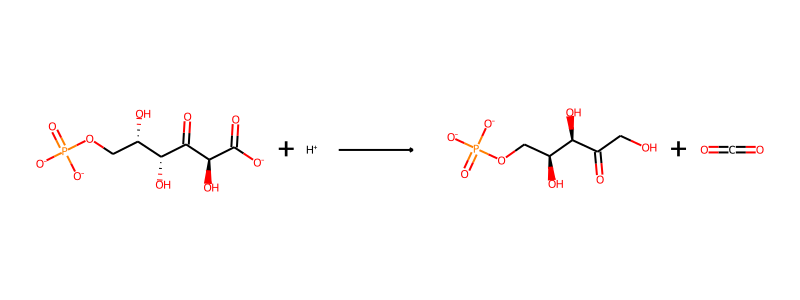

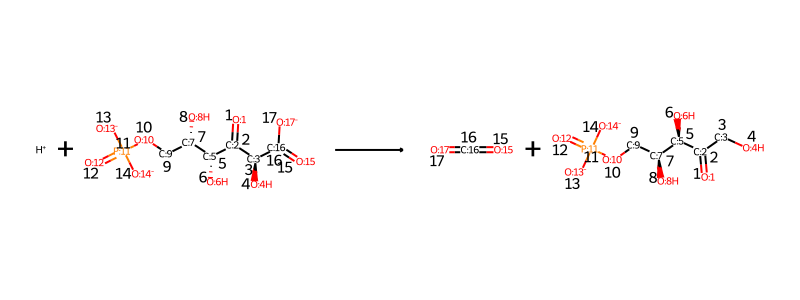

In [9]:
print(mcsa_dataset_df[['alphafolddb-id']].loc[90])
for rxn in mcsa_dataset_df[['rxn_smiles', 'mapped_rxn_smiles']].loc[90].tolist():
    display(SVG(draw_chemical_reaction(rxn)))


In [10]:
# retro_templates = []
# erro_msgs = []

# for idx, mapped_rxn_smiles in tqdm(enumerate(mcsa_dataset_df['mapped_rxn_smiles'].tolist()), total=len(mcsa_dataset_df)):
#     tpl, erro_template, rxn_smi = get_templates(mapped_rxn_smiles, add_brackets=True)
#     retro_templates.append(tpl)
#     if tpl == '':
#         erro_msgs.append((idx, erro_template, rxn_smi))

In [14]:
mcsa_dataset_df['retro_templates'] = mcsa_dataset_df.progress_apply(lambda row: get_templates(row['mapped_rxn_smiles'], add_brackets=True, validate=False), axis=1)

100%|██████████| 957/957 [00:23<00:00, 40.56it/s]
/home/xiaoruiwang/software/miniconda3/envs/retro_planner_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
(mcsa_dataset_df['retro_templates'] == '').sum()

38

In [12]:
# len(erro_msgs)

In [13]:
# index, erro_templates, rxn_smiles = erro_msgs[190]
# print(erro_templates)
# print(rxn_smiles)
# display(SVG(draw_chemical_reaction_templates(erro_templates)))
# display(SVG(draw_chemical_reaction(rxn_smiles)))
# rct = rdchiralReactants(rxn_smiles.split(">")[-1])
# try:
#     rxn = rdchiralReaction(erro_templates)
#     outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
# except:
#     outcomes =[]

# print('outcomes:')
# for smiles in outcomes:
#     print(smiles)
#     display(Chem.MolFromSmiles(smiles))
# print('GT reactants:')  
# print(get_fixed_prec(rxn_smiles))
# display(Chem.MolFromSmiles(get_fixed_prec(rxn_smiles)))

# 这里的错误有203条，大部分是因为多位点反应而产生的错误，模板本身是正确的，所以在抽取模板时不进行模板验证。    

In [17]:
mcsa_dataset_df.to_csv('../dataset/mcsa_fine_tune/normal_mcsa/mcsa_dataset_add_retro_templates.csv', index=False)
mcsa_dataset_df

,reaction,ec,alphafolddb-id,aa_sequence,site_labels,site_types,cluster,ec_level1,dataset_flag,rxn_smiles,mapped_rxn_smiles,retro_templates
0,CC1C(=O)N(C)C1C.O|MSIQHFRVALIPFFAAFCLPVFAHPETL...,3.5.2.6,P62593,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,"[[68], [71], [128], [164], [232], [235]]",NaN,Cluster 18632,3,train,CC1C(=O)N(C)C1C.O>>CC(=O)N[C@H](C(=O)O)C1N[C@@...,[CH3:1][N:4]1[C:2](=[O:3])[CH:15]([CH3:16])[CH...,([C;D1;H3:1]-[C;H0;D4;+0:2].[CH3;D1;+0:6]-[C;H...
1,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,1.6.5.2,P15559,MVGRRALIVLAHSERTSFNYAMKEAAAAALKKKGWEVVESDLYAMN...,"[[150], [156], [162]]",NaN,Cluster 19381,1,train,CC1=C(C)C(=O)C(C)=C(C)C1=O.NC(=O)C1=CN([C@@H]2...,[CH3:1][C:2]1=[C:3]([CH3:4])[C:5](=[O:6])[C:7]...,([#8:1]-[C:2]-[n+;H0;D3:3]1:[cH;D2;+0:4]:[cH;D...
2,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,1.8.1.7,P00390,MALLPRALSAGAGPSWRRAARAFRGFLLLLPEPAALTRALSRAMAC...,"[[102], [107], [110], [241], [245], [511], [516]]",NaN,Cluster 2616,1,train,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:48][N:8]([...,([#8:1]-[C:2]-[n+;H0;D3:3]1:[cH;D2;+0:4]:[c;H0...
3,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,2.4.2.19,P9WJJ7,MGLSDWELAAARAAIARGLDEDLRYGPDVTTLATVPASATTTASLV...,"[[105], [140], [172], [201], [222]]",NaN,Cluster 18704,2,train,O=C([O-])c1cccnc1C(=O)[O-].O=P([O-])([O-])OC[C...,[C@H:9]1([O:28][P:27](=[O:26])([O-:29])[O:30][...,([#15:3]-[O-;H0;D1:4].[#15:1]-[OH;D1;+0:2].[#8...
4,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,2.5.1.6,P31153,MNGQLNGFHEAFIEEGTFLFTSESVGEGHPDKICDQISDAVLDAHL...,"[[29], [31], [32], [57], [70], [181], [250], [...",NaN,Cluster 9717,2,train,CSCC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[C@@H...,[CH2:10]([C@H:11]1[O:12][C@@H:13]([n:14]2[cH:1...,([#8:1]-[C:2]-[CH2;D2;+0:3]-[S+;H0;D3:14](-[C:...
...,...,...,...,...,...,...,...,...,...,...,...,...
961,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,6.1.1.20,P27001,MLEEALAAIQNARDLEELKALKARYLGKKGLLTQEMKGLSALPLEE...,"[[149], [178], [204], [218], [261], [314]]",NaN,Cluster 13284,6,test,CP(=O)([O-])OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[...,[C:24](=[O:25])([C@@H:26]([NH3+:27])[CH2:28][c...,([#15:1]-[O-;H0;D1:2].[C:9]-[O;H0;D2;+0:10]-[C...
962,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...,6.3.5.4,P22106,MCSIFGVFDIKTDAVELRKKALELSRLMRHRGPDWSGIYASDNAIL...,"[[2], [51], [75], [76], [322], [325]]",NaN,Cluster 1460,6,test,NC(=O)CC[C@H]([NH3+])C(=O)[O-].Nc1ncnc2c1ncn2[...,[C:2](=[O:3])([CH2:4][C@H:5]([NH3+:6])[C:7](=[...,([#15:1]-[O-;H0;D1:2].[C:13]-[C;H0;D3;+0:14](-...
963,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...,6.5.1.4,P46849,MKRMIALDGAQGEGGGQILRSALSLSMITGQPFTITSIRAGRAKPG...,"[[13], [308]]",NaN,Cluster 14477,6,test,C[C@H]1O[C@H](COP(C)(=O)[O-])[C@@H](OP(=O)([O-...,[CH3:1][C@H:2]1[O:3][C@H:4]([CH2:5][O:6][P:7](...,([#15:1]-[O-;H0;D1:2].[#8:9]-[P;H0;D4;+0:10](-...
964,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...,6.1.2.1,P25051,MNRIKVAILFGGCSEEHDVSVKSAIEIAANINKEKYEPLYIGITKS...,"[[19], [22], [99], [244], [250], [290], [311],...",NaN,Cluster 13982,6,test,C[C@@H](O)C(=O)[O-].C[C@@H]([NH3+])C(=O)[O-].N...,[CH3:1][C@@H:2]([NH3+:3])[C:4](=[O:5])[O-:42]....,([#15:1]-[O-;H0;D1:2].[C:7]-[C;H0;D3;+0:8](=[O...
